<a href="https://www.kaggle.com/code/mehranommani/car-price?scriptVersionId=198874571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [2]:
import pandas as pd

# Load the datasets
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


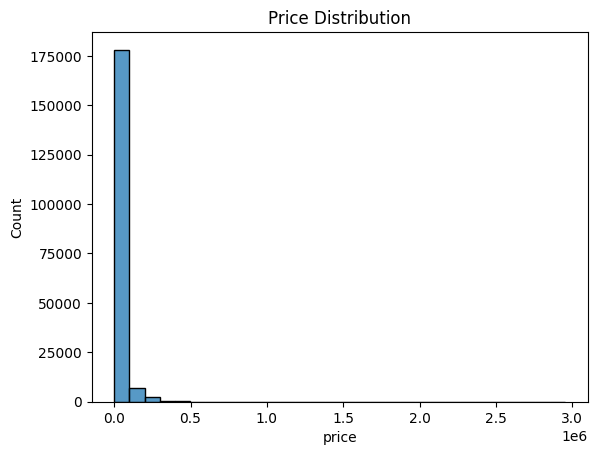

In [3]:
# Visualizations can include histograms, box plots, etc.
import matplotlib.pyplot as plt
import seaborn as sns

# Display first few rows of the dataset
print(train.head())

# Check for missing values
print(train.isnull().sum())
sns.histplot(train['price'], bins=30)
plt.title('Price Distribution')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


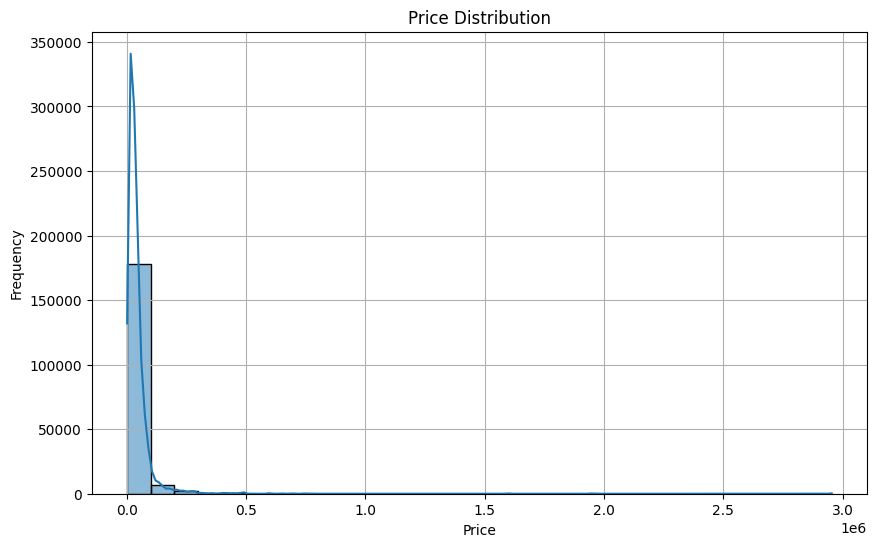

In [4]:
# Plotting the distribution of the price
plt.figure(figsize=(10, 6))
sns.histplot(train['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [5]:
import pandas as pd
import numpy as np
import re

# Define a function for all preprocessing steps
def preprocess_data(df):
    # Step 1: Convert fuel_type to numeric using Label Encoding
    df['fuel_type'] = df['fuel_type'].astype('category').cat.codes

    # Step 2: Extract numeric values from the `engine` column
    def extract_engine_features(engine_str):
        hp = float(re.search(r'(\d+\.?\d*)HP', engine_str).group(1)) if re.search(r'(\d+\.?\d*)HP', engine_str) else np.nan
        size = float(re.search(r'(\d+\.?\d*)L', engine_str).group(1)) if re.search(r'(\d+\.?\d*)L', engine_str) else np.nan
        cylinders = int(re.search(r'(\d+) Cylinder', engine_str).group(1)) if re.search(r'(\d+) Cylinder', engine_str) else np.nan
        
        return pd.Series([hp, size, cylinders])

    # Apply the function to extract features
    df[['engine_hp', 'engine_size', 'engine_cylinders']] = df['engine'].apply(extract_engine_features)

    # Step 3: Drop the original engine column
    df.drop(columns=['engine'], inplace=True)

    # Step 4: Function to classify and encode transmission type
    def encode_transmission(trans):
        if any(x in trans for x in ['A/T', 'Automatic', 'CVT', 'DCT']):
            return 2  # Automatic
        elif any(x in trans for x in ['M/T', 'Manual']):
            return 1  # Manual
        else:
            return 0  # Other

    # Step 5: Function to extract gear speed
    def extract_gears(trans):
        if trans in ['A/T', 'Automatic', 'CVT', 'DCT']:
            return 2
        match = re.search(r'(\d+)-Speed|(\d+)', trans)
        if match:
            return int(match.group(1) or match.group(2))
        return np.nan

    # Step 6: Apply the functions to the DataFrame
    df['gear_speed'] = df['transmission'].apply(extract_gears)
    df['transmission'] = df['transmission'].apply(encode_transmission)

    # Step 7: Fill missing values for gear_speed with a placeholder (0 or another meaningful value)
    df['gear_speed'].fillna(0, inplace=True)

    # Step 8: Map values in the 'accident' column to numeric values
    mapping = {
        'None reported': 0,
        'At least 1 accident or damage reported': 1
    }
    df['accident'] = df['accident'].map(mapping)

    # Step 9: Fill missing values in 'accident' with a default value (0 or another meaningful value)
    df['accident'].fillna(0, inplace=True)

    # Step 10: Fill missing values for numerical columns with the median
    df['engine_hp'] = df['engine_hp'].fillna(df['engine_hp'].median())
    df['engine_size'] = df['engine_size'].fillna(df['engine_size'].median())
    df['engine_cylinders'] = df['engine_cylinders'].fillna(df['engine_cylinders'].median())

    # Step 11: Drop the clean_title column (if it exists)
    df = df.drop(columns=['clean_title'], errors='ignore')

    return df

# Apply preprocessing to both train and test datasets
train = preprocess_data(train)
test = preprocess_data(test)

/tmp/ipykernel_23/3073558578.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gear_speed'].fillna(0, inplace=True)
/tmp/ipykernel_23/3073558578.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [6]:
# Display the rows of the processed train
train

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,price,engine_hp,engine_size,engine_cylinders,gear_speed
0,0,MINI,Cooper S Base,2007,213000,2,2,Yellow,Gray,0.0,4200,172.0,1.6,4.0,2.0
1,1,Lincoln,LS V8,2002,143250,2,2,Silver,Beige,1.0,4999,252.0,3.9,8.0,2.0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,1,2,Blue,Gray,0.0,13900,320.0,5.3,8.0,2.0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,2,0,Black,Black,0.0,45000,420.0,5.0,8.0,0.0
4,4,Mercedes-Benz,Metris Base,2021,7388,2,2,Black,Beige,0.0,97500,208.0,2.0,4.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,2,0,White,Beige,0.0,27500,420.0,6.2,8.0,0.0
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,2,2,White,Black,1.0,30000,385.0,3.0,6.0,8.0
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,2,2,White,Black,0.0,86900,469.0,4.0,8.0,7.0
188531,188531,Audi,S5 3.0T Prestige,2022,13895,2,2,Daytona Gray Pearl Effect,Black,0.0,84900,329.0,3.0,6.0,1.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                188533 non-null  int64  
 1   brand             188533 non-null  object 
 2   model             188533 non-null  object 
 3   model_year        188533 non-null  int64  
 4   milage            188533 non-null  int64  
 5   fuel_type         188533 non-null  int8   
 6   transmission      188533 non-null  int64  
 7   ext_col           188533 non-null  object 
 8   int_col           188533 non-null  object 
 9   accident          188533 non-null  float64
 10  price             188533 non-null  int64  
 11  engine_hp         188533 non-null  float64
 12  engine_size       188533 non-null  float64
 13  engine_cylinders  188533 non-null  float64
 14  gear_speed        188533 non-null  float64
dtypes: float64(5), int64(5), int8(1), object(4)
memory usage: 20.3+ MB


In [8]:
# from catboost import CatBoostRegressor

# # Define the categorical features
# cat_features = ['brand', 'model', 'ext_col', 'int_col']  # Categorical column names or indices

# # Initialize the model
# cat_model = CatBoostRegressor(iterations=500, depth=8, learning_rate=0.1, loss_function='RMSE', cat_features=cat_features)

# # Train the model
# cat_model.fit(train.drop(columns=['id', 'price']), train['price'], cat_features=cat_features)

In [9]:
test

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,engine_hp,engine_size,engine_cylinders,gear_speed
0,188533,Land,Rover LR2 Base,2015,98000,2,2,White,Beige,0.0,240.0,2.0,4.0,6.0
1,188534,Land,Rover Defender SE,2020,9142,3,2,Silver,Black,0.0,395.0,3.0,6.0,8.0
2,188535,Ford,Expedition Limited,2022,28121,2,2,White,Ebony,0.0,328.0,3.5,6.0,10.0
3,188536,Audi,A6 2.0T Sport,2016,61258,2,2,Silician Yellow,Black,0.0,328.0,3.5,6.0,2.0
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,2,2,Gray,Black,0.0,252.0,2.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,314218,Mercedes-Benz,GL-Class GL 450 4MATIC,2014,83315,2,2,Black,Black,0.0,362.0,3.0,6.0,7.0
125686,314219,Audi,Q7 55 Prestige,2019,29336,2,2,White,Black,0.0,328.0,3.5,6.0,2.0
125687,314220,Audi,A6 3.0T Premium Plus,2012,77634,2,2,Black,Black,0.0,333.0,3.0,6.0,2.0
125688,314221,Audi,Q7 3.0T Premium,2012,112000,2,2,Black,Black,0.0,333.0,3.0,6.0,2.0


In [10]:
# # Make predictions on the test set
# test_predictions = cat_model.predict(test.drop(columns=['id']))

# # Create a submission DataFrame
# submission = pd.DataFrame({
#     'id': test['id'],           # Use the test set 'id' column
#     'price': test_predictions    # Predicted prices
# })

# # Save the submission to a CSV file
# submission.to_csv('submission.csv', index=False)

# print("Submission file saved as 'submission.csv'")

In [11]:
target_mean = train.groupby('brand')['price'].mean()
train['brand_encoded'] = train['brand'].map(target_mean)
test['brand_encoded'] = test['brand'].map(target_mean)

In [12]:
def car_name(df):
    df = df.drop(columns=['ext_col'], errors='ignore')
    df = df.drop(columns=['int_col'], errors='ignore')
    df = df.drop(columns=['brand'], errors='ignore')
    df = df.drop(columns=['model'], errors='ignore')
    return df

# Apply preprocessing to both train and test datasets
train = car_name(train)
test = car_name(test)

In [13]:
train

,id,model_year,milage,fuel_type,transmission,accident,price,engine_hp,engine_size,engine_cylinders,gear_speed,brand_encoded
0,0,2007,213000,2,2,0.0,4200,172.0,1.6,4.0,2.0,17162.015977
1,1,2002,143250,2,2,1.0,4999,252.0,3.9,8.0,2.0,30712.595130
2,2,2002,136731,1,2,0.0,13900,320.0,5.3,8.0,2.0,41836.755127
3,3,2017,19500,2,0,0.0,45000,420.0,5.0,8.0,0.0,53556.327141
4,4,2021,7388,2,2,0.0,97500,208.0,2.0,4.0,7.0,51244.399541
...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,2017,49000,2,0,0.0,27500,420.0,6.2,8.0,0.0,45659.094780
188529,188529,2018,28600,2,2,1.0,30000,385.0,3.0,6.0,8.0,51244.399541
188530,188530,2021,13650,2,2,0.0,86900,469.0,4.0,8.0,7.0,51244.399541
188531,188531,2022,13895,2,2,0.0,84900,329.0,3.0,6.0,1.0,41004.856985


In [14]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming train and test datasets are already preprocessed

# Best parameters obtained from the previous search
best_params_lgb = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'max_depth': 5,
    'n_estimators': 100,
    'num_leaves': 31,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'subsample': 0.8
}

# Prepare the features and target variable
X_train = train.drop(columns=['price'])
y_train = train['price']
X_test = test  # Ensure test set is preprocessed similarly

# Create the LightGBM model with verbosity level
lgb_model = lgb.LGBMRegressor(**best_params_lgb, verbosity=1)

# Train the model
lgb_model.fit(X_train, y_train, eval_metric='rmse')

# Make predictions on the test set
predictions = lgb_model.predict(X_test)

# Ensure predictions are in the correct format
submission = pd.DataFrame({
    'id': test['id'],  # Ensure 'id' is present in the test dataset
    'price': predictions
})

# Save the results to a CSV file in the required format
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' has been created successfully.")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 188533, number of used features: 11
[LightGBM] [Info] Start training from score 43878.016178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning